In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import logging
import multiprocessing
import gensim
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input
from keras.layers.embeddings import Embedding

In [21]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [100]:
from keras import backend as K


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [4]:
n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('D:\Programming\Data\\positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('D:\Programming\Data\\negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

#сбалансированный датасет
sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['text'].values[:sample_size],
                           data_negative['text'].values[:sample_size]), axis=0)
labels = [1] * sample_size + [0] * sample_size

In [19]:
with open('D:\Programming\Data\\2Wec.txt', 'w', encoding='utf-8') as f:
    for i in data_positive['text']:
        rasp = i.split(' ')
        text=''
        for j in rasp:
            if j.find('@')==-1 and j!='RT' and j.find('http')==-1:
                text=text+' '+j
        print(text,file=f)
    for i in data_negative['text']:
        rasp = i.split(' ')
        text=''
        for j in rasp:
            if j.find('@')==-1:
                text=text+' '+j
        print(text,file=f)

In [22]:
data = [preprocess_text(t) for t in raw_data]
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
data = gensim.models.word2vec.LineSentence('D:\Programming\Data\\2Wec.txt') 
model = Word2Vec(data, size=200, window=5, min_count=3, workers=multiprocessing.cpu_count())

In [24]:
model.save("D:\Programming\Data\\model2Wec.w2v")

2020-08-26 21:20:05,204 : INFO : collecting all words and their counts
2020-08-26 21:20:05,206 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-26 21:20:05,349 : INFO : PROGRESS: at sentence #10000, processed 94710 words, keeping 34916 word types
2020-08-26 21:20:05,426 : INFO : PROGRESS: at sentence #20000, processed 187941 words, keeping 61349 word types
2020-08-26 21:20:05,495 : INFO : PROGRESS: at sentence #30000, processed 283680 words, keeping 85158 word types
2020-08-26 21:20:05,593 : INFO : PROGRESS: at sentence #40000, processed 376614 words, keeping 106186 word types
2020-08-26 21:20:05,710 : INFO : PROGRESS: at sentence #50000, processed 474515 words, keeping 126652 word types
2020-08-26 21:20:05,779 : INFO : PROGRESS: at sentence #60000, processed 568676 words, keeping 146120 word types
2020-08-26 21:20:05,847 : INFO : PROGRESS: at sentence #70000, processed 659277 words, keeping 163927 word types
2020-08-26 21:20:05,927 : INFO : PROGRESS: 

In [109]:
SENTENCE_LENGTH = 26
# Размер словаря
NUM = 100000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

# Токенизатор
tokenizer = Tokenizer(num_words=NUM)
#tokenizer.fit_on_texts(x_train)

#x_train_seq = get_sequences(tokenizer, x_train)
#x_test_seq = get_sequences(tokenizer, x_test)

In [64]:
w2v_model = Word2Vec.load('D:\Programming\Data\\model2Wec.w2v')
DIM = w2v_model.vector_size 
# Инициализируем матрицу embedding слоя нулями
embedding_matrix = np.zeros((NUM, DIM))
# Добавляем NUM=100000 наиболее часто встречающихся слов из обучающей выборки в embedding слой
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in w2v_model.wv.vocab.keys():
        embedding_matrix[i] = w2v_model.wv[word]

2020-08-26 21:57:07,110 : INFO : loading Word2Vec object from D:\Programming\Data\model2Wec.w2v
2020-08-26 21:57:07,323 : INFO : loading wv recursively from D:\Programming\Data\model2Wec.w2v.wv.* with mmap=None
2020-08-26 21:57:07,324 : INFO : loading vectors from D:\Programming\Data\model2Wec.w2v.wv.vectors.npy with mmap=None
2020-08-26 21:57:07,359 : INFO : setting ignored attribute vectors_norm to None
2020-08-26 21:57:07,360 : INFO : loading vocabulary recursively from D:\Programming\Data\model2Wec.w2v.vocabulary.* with mmap=None
2020-08-26 21:57:07,362 : INFO : loading trainables recursively from D:\Programming\Data\model2Wec.w2v.trainables.* with mmap=None
2020-08-26 21:57:07,363 : INFO : loading syn1neg from D:\Programming\Data\model2Wec.w2v.trainables.syn1neg.npy with mmap=None
2020-08-26 21:57:07,398 : INFO : setting ignored attribute cum_table to None
2020-08-26 21:57:07,399 : INFO : loaded D:\Programming\Data\model2Wec.w2v


In [65]:
tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(tweet_input)

In [66]:
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D

branches = []
x = Dropout(0.2)(tweet_encoder)

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
# Конкатенируем карты признаков
x = concatenate(branches, axis=1)
# Добавляем dropout-регуляризацию
x = Dropout(0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=[tweet_input], outputs=[output])

In [68]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, recall, f1])
#model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 26)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 26, 200)      20000000    input_14[0][0]                   
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 26, 200)      0           embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_120 (Conv1D)             (None, 25, 1)        401         dropout_6[0][0]                  
_______________________________________________________________________________________

In [74]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("D:\Programming\Data\\modelsdir\\cnn-frozen-embeddings-{epoch:02d}-{val_f1:.2f}.hdf5",
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(x_train_seq, np.array(y_train), batch_size=32, epochs=10, validation_split=0.25, callbacks = [checkpoint])

2020-08-26 21:58:59,930 : WARNING : `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Epoch 1/10
4198/4198 [==============================] - 332s 79ms/step - loss: 0.6486 - precision: 0.6164 - recall: 0.6371 - f1: 0.6159 - val_loss: 0.6228 - val_precision: 0.6237 - val_recall: 0.7560 - val_f1: 0.6770
Epoch 2/10
4198/4198 [==============================] - 336s 80ms/step - loss: 0.6251 - precision: 0.6395 - recall: 0.6772 - f1: 0.6494 - val_loss: 0.6088 - val_precision: 0.6601 - val_recall: 0.6641 - val_f1: 0.6547
Epoch 3/10
4198/4198 [==============================] - 323s 77ms/step - loss: 0.6161 - precision: 0.6500 - recall: 0.6829 - f1: 0.6576 - val_loss: 0.6078 - val_precision: 0.6854 - val_recall: 0.6022 - val_f1: 0.6332
Epoch 4/10
4198/4198 [==============================] - 331s 79ms/step - loss: 0.6102 - precision: 0.6540 - recall: 0.6914 - f1: 0.6643 - val_loss: 0.6007 - val_precision: 0.6836 - val_recall: 0.6422 - val_f1: 0.6548
Epoch 5/10
4198/4198 [==============================] - 329s 78ms/step - loss: 0.6058 - precision: 0.6559 - recall: 0.7002 - f1: 0.6

In [76]:
model.save('D:\Programming\Data\\cnn')

2020-08-26 22:56:28,194 : WARNING : From C:\Users\61515\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-08-26 22:56:28,239 : WARNING : From C:\Users\61515\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-08-26 22:56:37,948 : INFO : Assets written to: D:\Programming\Data\cnn\assets


In [101]:
import keras
model = keras.models.load_model('D:\Programming\Data\\cnn',
                                custom_objects={'f1':f1, 'precision':precision, 'recall':recall})

In [82]:
comment=get_sequences(tokenizer, ['А прошлым вечером ногу отпилил ради этой шутки'])
print(model.predict(comment))

[[0.33419538]]


In [81]:
from selenium import webdriver
import time

In [84]:
driver = webdriver.Chrome('D:\Programming\chromedriver_win32\chromedriver.exe')

In [89]:
path='https://pikabu.ru/story/kak_vospitat_besshumnogo_nindzyu_7674675'
driver.get(path)
while True:
    try:
        button = driver.find_element_by_class_name('button_width_100 comments__more-button')
        button.click()
        time.sleep(10)
    except:
        break
    
elem = driver.find_elements_by_xpath("//div[@class='page-story__comments']//*[@class='comment__content']")

In [127]:
tokenizer.fit_on_texts([comment.text for comment in elem])

comment=get_sequences(tokenizer, [comment.text for comment in elem])
predictions=model.predict(comment)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E8E65C50F0>]],
      dtype=object)

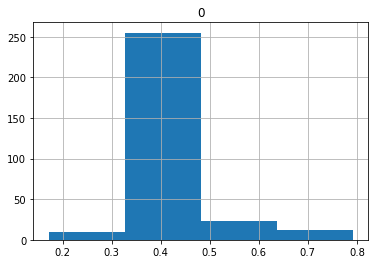

In [225]:
import pandas as pd

comments_data=pd.DataFrame(data=(np.array(predictions)))
comments_data.hist(bins=4)

In [161]:
bot=comments_data[comments_data[0]<0.25]
mid=comments_data[(comments_data[0]>0.25) & (comments_data[0]<0.75)]
top=comments_data[comments_data[0]>0.75]

In [190]:
def eq(x):
    if x>0.75: return 'top'
    if x<=0.75 and x>=0.25: return 'mid'
    if x<0.25: return 'bot'

comments_data['rang']=pd.Series([eq(x) for x in comments_data[0]], dtype="category")

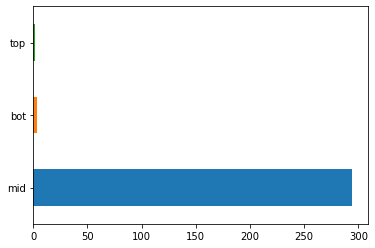

In [200]:
comments_data.rang.value_counts().plot(kind='barh')

In [217]:
import datetime
driver.get(path)
while True:
    try:
        button = driver.find_element_by_class_name('button_width_100 comments__more-button')
        button.click()
        time.sleep(10)
    except:
        break
    
elem = driver.find_elements_by_xpath(
    "//div[@class='page-story__comments']//*[@class='comment__header']//*[@class='comment__datetime hint']")
dates=[datetime.datetime.strptime((date.get_attribute('datetime'))[0:10], "%Y-%m-%d") for date in elem]

In [229]:
comments_count=pd.Series(pd.Series(dates).value_counts())

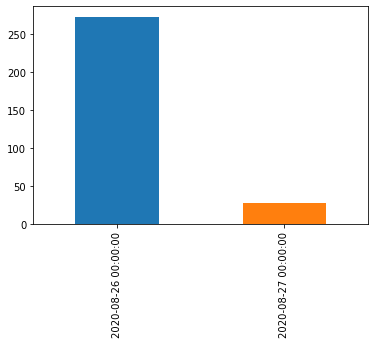

In [234]:
comments_count.plot(kind='bar')